## Вебинар 2. (Выполнение домашнего задания - ниже)

In [201]:
import pandas as pd

In [202]:
news = pd.read_csv("materials.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [203]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [204]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [205]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [206]:
import nltk
nltk.download('stopwords')
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

[nltk_data] Downloading package stopwords to C:\Users\Олег
[nltk_data]     Иванович\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [207]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [208]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [209]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

Wall time: 26.5 s


In [210]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 3min 37s


А теперь в 3 строчки обучим нашу модель

In [211]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [212]:
common_dictionary[10]

'ватутин'

Все просто - это словарь наших слов

Запускаем обучение

In [213]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 31.2 s


In [214]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [215]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(5, 0.16150284),
 (7, 0.66939217),
 (13, 0.039554488),
 (19, 0.083690554),
 (24, 0.027913481)]

In [216]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: смерть рак снятие помещение кит городок вырабатывать
topic_1: банк тело источник полиция штат год местный
topic_2: диапазон рекорд музыка си мексиканский специализироваться побить
topic_3: женщина гражданин nn мозг мужчина россиянин место
topic_4: украина украинский гражданин продукция фронт памятник народный
topic_5: год который nn стать первый фонд журнал
topic_6: операция земля это день который болезнь убийство
topic_7: эксперимент восток вирус солнце дальний употребление победа
topic_8: год статья ребёнок который обнаружить район это
topic_9: путин пресссекретарить президент владимир песок доклад определение
topic_10: космос министерство школа атмосферный общество разбираться ученик
topic_11: погибнуть бомба сооружение медик казахстан таиланд концерн
topic_12: россия российский это газ эксперт рынок год
topic_13: выяснить пострадать торговый препарат участок применение след
topic_14: год млн цена это составить экономика фонд
topic_15: ракета запуск сша км nn освобождение о

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [217]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [218]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.251046,0.0,0.0,0.000000,0.034945,0.000000,0.054560,0.000000,...,0.0,0.0,0.00000,0.0,0.631207,0.0,0.000000,0.020882,0.0,0.0
1,4896,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.355146,0.000000,...,0.0,0.0,0.00000,0.0,0.000000,0.0,0.032166,0.150235,0.0,0.0
2,4897,0.0,0.000000,0.0,0.0,0.000000,0.139320,0.000000,0.678307,0.000000,...,0.0,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.162674,0.0,0.0
3,4898,0.0,0.000000,0.0,0.0,0.018617,0.196307,0.404931,0.185272,0.000000,...,0.0,0.0,0.18539,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0
4,4899,0.0,0.000000,0.0,0.0,0.498673,0.256927,0.000000,0.000000,0.178625,...,0.0,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [219]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [220]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [221]:
doc_dict[293622]

array([0.        , 0.07265259, 0.01301424, 0.08066191, 0.        ,
       0.29331517, 0.        , 0.        , 0.        , 0.05576244,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.02161499, 0.        , 0.11832539, 0.        , 0.        ,
       0.        , 0.19192612, 0.14301607, 0.        , 0.        ])

In [222]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [223]:
get_user_embedding(user_articles_list)

array([0.        , 0.00832208, 0.        , 0.02759892, 0.02123873,
       0.025346  , 0.06235501, 0.        , 0.0195918 , 0.06422409,
       0.00262657, 0.        , 0.08863291, 0.        , 0.00189141,
       0.01389238, 0.02699689, 0.07408071, 0.        , 0.18641451,
       0.00385671, 0.29496295, 0.04827173, 0.01541533, 0.        ])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [224]:
users['articles'].iloc[33]

'[323329, 321961, 324743, 323186, 324632, 474690]'

In [225]:
" ".join(news[news['doc_id']==323186]['title'].iloc[0])

'глава российский мид сергей лавров опровергнуть появиться сми информация якобы готовиться обмен декларация россия сша сотрудничество сфера сообщать риа новость nn читать сообщение разговаривать автор сообщение знать откуда автор источник какихлибо основание подобный род репортаж знать откуда информация появиться сказать журналист итог встреча госсекретарь сша джон керри nn позиция свой изложить декларация напринимать достаточно рамка обсе рамка совет россия нато высокий уровень продекларировать всё обеспечивать неделимость безопасность никто обеспечивать свой безопасность счёт безопасность продолжить министр слово лавров москва считать система нато создавать проблема наш безопасность поэтому декларация недостаточно мочь договариваться совместный система россия предлагать ещё начинать год президент путин посещать сша нужно вести речь очередной декларация гарантия который проверять объективный военнотехнический критерий гарантия ненаправленность система против российский ядерный потенци

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [226]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.025059,0.002169,0.013444,0.037490,0.164004,0.078356,0.000000,0.067632,...,0.014420,0.016792,0.064237,0.0,0.160156,0.015867,0.163920,0.088676,0.000000,0.000000
1,u108690,0.008126,0.030886,0.000000,0.003161,0.037355,0.025743,0.041106,0.000000,0.065612,...,0.006771,0.026906,0.098813,0.0,0.241554,0.007158,0.232251,0.030967,0.018957,0.003729
2,u108339,0.000000,0.057264,0.000000,0.058471,0.014128,0.020786,0.117025,0.005495,0.069969,...,0.000000,0.035979,0.070838,0.0,0.136013,0.016471,0.240563,0.030710,0.027101,0.011152


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [227]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [228]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.025059,0.002169,0.013444,0.037490,0.164004,0.078356,0.000000,0.067632,...,0.016792,0.064237,0.0,0.160156,0.015867,0.163920,0.088676,0.000000,0.000000,0
1,u108690,0.008126,0.030886,0.000000,0.003161,0.037355,0.025743,0.041106,0.000000,0.065612,...,0.026906,0.098813,0.0,0.241554,0.007158,0.232251,0.030967,0.018957,0.003729,1
2,u108339,0.000000,0.057264,0.000000,0.058471,0.014128,0.020786,0.117025,0.005495,0.069969,...,0.035979,0.070838,0.0,0.136013,0.016471,0.240563,0.030710,0.027101,0.011152,1


In [229]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [230]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [231]:
logreg = RandomForestClassifier()
#обучим 
logreg.fit(X_train, y_train)

RandomForestClassifier()

In [232]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.1 , 0.01, 0.98, 0.01, 0.03, 0.02, 0.08, 0.  , 0.07, 0.14])

In [233]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [234]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.410000, F-Score=0.832, Precision=0.881, Recall=0.788


In [235]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1730   25]
 [  55  190]]


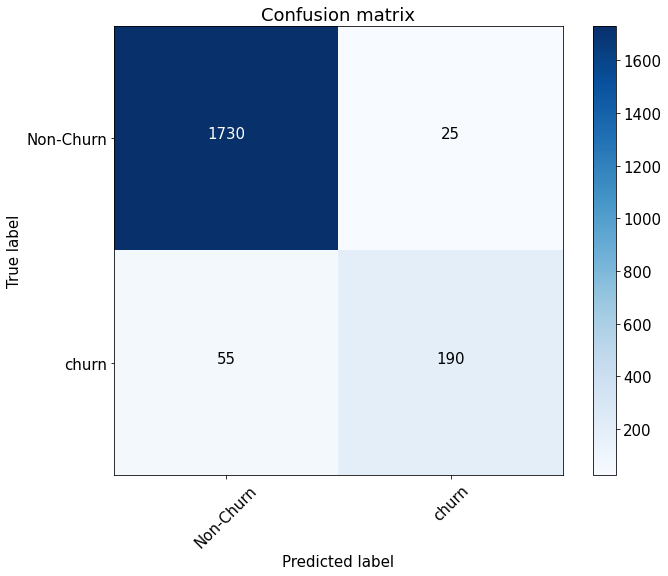

In [236]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [237]:
roc_auc_score(y_test, preds)

0.9779836036978893

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

### Домашнее задание

2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

In [238]:
def get_user_embedding_2(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    # print(user_vector)
    user_vector = np.median(user_vector, 0)  # медиана
    return user_vector

In [239]:
user_articles_list #= users['articles'].iloc[33]

uv_1 = get_user_embedding(user_articles_list)
uv_2 = get_user_embedding_2(user_articles_list, doc_dict)

print(user_articles_list)
print(uv_1)
print(uv_2)

[323329, 321961, 324743, 323186, 324632, 474690]
[0.         0.00832208 0.         0.02759892 0.02123873 0.025346
 0.06235501 0.         0.0195918  0.06422409 0.00262657 0.
 0.08863291 0.         0.00189141 0.01389238 0.02699689 0.07408071
 0.         0.18641451 0.00385671 0.29496295 0.04827173 0.01541533
 0.        ]
[0.         0.         0.         0.         0.01111626 0.
 0.         0.         0.         0.0074925  0.         0.
 0.08158799 0.         0.         0.01232722 0.         0.06738105
 0.         0.20633574 0.         0.37910175 0.00911657 0.
 0.        ]


In [240]:
N_topic = 25

In [241]:
%%time
user_embeddings_2 = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_2(x, doc_dict))])
user_embeddings_2.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings_2['uid'] = users['uid'].values
user_embeddings_2 = user_embeddings_2[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings_2.head(3)

Wall time: 708 ms


,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.018710,0.0,0.00000,0.006881,0.198403,0.064643,0.0,0.036358,...,0.00000,0.000000,0.053730,0.0,0.126939,0.0000,0.183640,0.100168,0.000000,0.0
1,u108690,0.0,0.000000,0.0,0.00000,0.036154,0.016343,0.034413,0.0,0.043840,...,0.00515,0.000000,0.078177,0.0,0.243227,0.0000,0.229737,0.020937,0.000000,0.0
2,u108339,0.0,0.066207,0.0,0.03247,0.000000,0.010339,0.129824,0.0,0.064978,...,0.00000,0.030321,0.047381,0.0,0.117226,0.0074,0.249355,0.019096,0.005159,0.0


In [242]:
X_2 = pd.merge(user_embeddings_2, target, 'left')
X_2.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.018710,0.0,0.00000,0.006881,0.198403,0.064643,0.0,0.036358,...,0.000000,0.053730,0.0,0.126939,0.0000,0.183640,0.100168,0.000000,0.0,0
1,u108690,0.0,0.000000,0.0,0.00000,0.036154,0.016343,0.034413,0.0,0.043840,...,0.000000,0.078177,0.0,0.243227,0.0000,0.229737,0.020937,0.000000,0.0,1
2,u108339,0.0,0.066207,0.0,0.03247,0.000000,0.010339,0.129824,0.0,0.064978,...,0.030321,0.047381,0.0,0.117226,0.0074,0.249355,0.019096,0.005159,0.0,1


In [243]:
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X_2['churn'], random_state=0)

In [244]:
logreg_2 = RandomForestClassifier()
logreg_2.fit(X_2_train, y_2_train)
preds_2 = logreg_2.predict_proba(X_2_test)[:, 1]
preds_2[:10]

array([0.19, 0.  , 0.98, 0.1 , 0.  , 0.  , 0.04, 0.  , 0.15, 0.05])

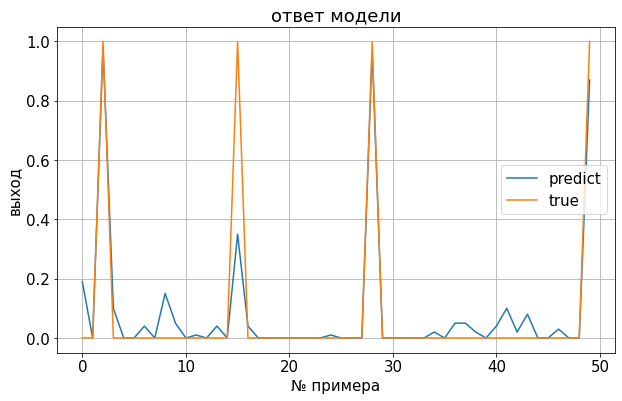

In [245]:
n = 50
plt.figure(figsize=(10, 6))
plt.plot(preds_2[:n], label='predict')
plt.plot(y_2_test.values[:n], label='true')
plt.title('ответ модели')
plt.xlabel('№ примера')
plt.ylabel('выход')
plt.legend()
plt.grid('On')
plt.show()

In [246]:
precision_2, recall_2, thresholds_2 = precision_recall_curve(y_2_test, preds_2)
# print(precision_2 + recall_2)
fscore_2 = (2 * precision_2 * recall_2) / (precision_2 + recall_2)
# locate the index of the largest f score
ix_2 = np.argmax(fscore_2)
print(f'Best Threshold={thresholds_2[ix_2]}, F-Score={fscore_2[ix_2]:.3f}, Precision={precision_2[ix_2]:.3f}, Recall={recall_2[ix_2]:.3f}')     

Best Threshold=0.31, F-Score=0.948, Precision=0.923, Recall=0.976


Confusion matrix, without normalization
[[1735   20]
 [   7  238]]


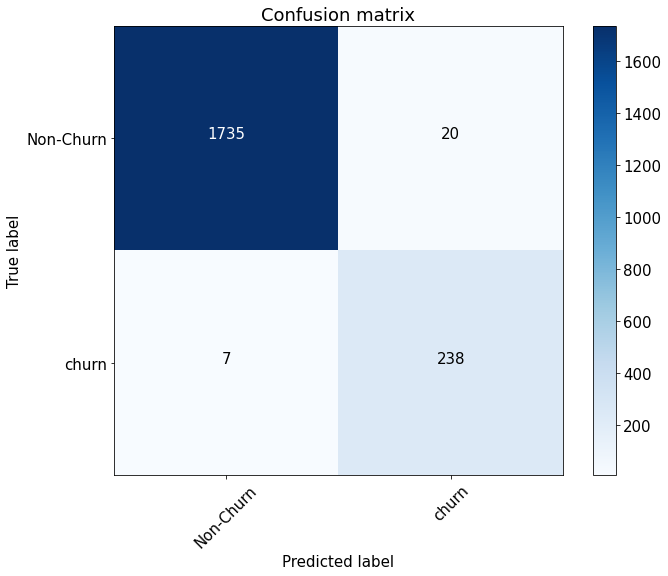

In [247]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_2 = confusion_matrix(y_2_test, preds_2 > thresholds_2[ix_2])

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_2, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [248]:
roc_auc_2 = roc_auc_score(y_2_test, preds_2)
roc_auc_2

0.9968230711087853

3. Повторить п.2, но используя уже не медиану, а max

In [249]:
def get_user_embedding_3(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    # print(user_vector)
    user_vector = np.max(user_vector, 0)  # медиана
    return user_vector

In [250]:
user_articles_list #= users['articles'].iloc[33]

uv_1 = get_user_embedding(user_articles_list)
uv_2 = get_user_embedding_2(user_articles_list, doc_dict)
uv_3 = get_user_embedding_3(user_articles_list, doc_dict)

print(user_articles_list)
print(uv_1)
print(uv_2)
print(uv_3)

[323329, 321961, 324743, 323186, 324632, 474690]
[0.         0.00832208 0.         0.02759892 0.02123873 0.025346
 0.06235501 0.         0.0195918  0.06422409 0.00262657 0.
 0.08863291 0.         0.00189141 0.01389238 0.02699689 0.07408071
 0.         0.18641451 0.00385671 0.29496295 0.04827173 0.01541533
 0.        ]
[0.         0.         0.         0.         0.01111626 0.
 0.         0.         0.         0.0074925  0.         0.
 0.08158799 0.         0.         0.01232722 0.         0.06738105
 0.         0.20633574 0.         0.37910175 0.00911657 0.
 0.        ]
[0.         0.0499325  0.         0.08672491 0.07061047 0.1299919
 0.37413004 0.         0.06284682 0.34195167 0.01575939 0.
 0.19370544 0.         0.01134848 0.03163147 0.1258236  0.15506287
 0.         0.32558328 0.02314026 0.52765322 0.22695649 0.09249201
 0.        ]


In [251]:
%%time
user_embeddings_3 = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_3(x, doc_dict))])
user_embeddings_3.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings_3['uid'] = users['uid'].values
user_embeddings_3 = user_embeddings_3[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings_3.head(3)

Wall time: 298 ms


,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.072653,0.013014,0.080662,0.128934,0.29390,0.194611,0.000000,0.224571,...,0.064904,0.070406,0.159638,0.0,0.540374,0.079137,0.347956,0.173797,0.000000,0.000000
1,u108690,0.038184,0.146408,0.000000,0.018965,0.094901,0.08329,0.103513,0.000000,0.143822,...,0.018271,0.138395,0.280581,0.0,0.487212,0.042946,0.374193,0.116888,0.103262,0.012294
2,u108339,0.000000,0.095372,0.000000,0.224056,0.084765,0.05562,0.158826,0.032968,0.183915,...,0.000000,0.088956,0.176221,0.0,0.269828,0.062986,0.395020,0.081175,0.103223,0.054481


In [252]:
user_embeddings_3.head()

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.072653,0.013014,0.080662,0.128934,0.293900,0.194611,0.000000,0.224571,...,0.064904,0.070406,0.159638,0.000000,0.540374,0.079137,0.347956,0.173797,0.000000,0.000000
1,u108690,0.038184,0.146408,0.000000,0.018965,0.094901,0.083290,0.103513,0.000000,0.143822,...,0.018271,0.138395,0.280581,0.000000,0.487212,0.042946,0.374193,0.116888,0.103262,0.012294
2,u108339,0.000000,0.095372,0.000000,0.224056,0.084765,0.055620,0.158826,0.032968,0.183915,...,0.000000,0.088956,0.176221,0.000000,0.269828,0.062986,0.395020,0.081175,0.103223,0.054481
3,u101138,0.000000,0.000000,0.000000,0.287174,0.112500,0.217572,0.085098,0.440024,0.097722,...,0.000000,0.067425,0.289137,0.000000,0.199863,0.276268,0.314176,0.141157,0.000000,0.000000
4,u108248,0.000000,0.180702,0.000000,0.116692,0.202296,0.188526,0.198423,0.022187,0.131653,...,0.026211,0.176361,0.353500,0.012515,0.338847,0.144903,0.295219,0.079666,0.032510,0.000000


In [253]:
X_3 = pd.merge(user_embeddings_3, target, 'left')
X_3.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.072653,0.013014,0.080662,0.128934,0.29390,0.194611,0.000000,0.224571,...,0.070406,0.159638,0.0,0.540374,0.079137,0.347956,0.173797,0.000000,0.000000,0
1,u108690,0.038184,0.146408,0.000000,0.018965,0.094901,0.08329,0.103513,0.000000,0.143822,...,0.138395,0.280581,0.0,0.487212,0.042946,0.374193,0.116888,0.103262,0.012294,1
2,u108339,0.000000,0.095372,0.000000,0.224056,0.084765,0.05562,0.158826,0.032968,0.183915,...,0.088956,0.176221,0.0,0.269828,0.062986,0.395020,0.081175,0.103223,0.054481,1


In [254]:
X_3_train, X_3_test, y_3_train, y_3_test = train_test_split(X_3[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X_3['churn'], random_state=0)
logreg_3 = RandomForestClassifier()
logreg_3.fit(X_3_train, y_3_train)
preds_3 = logreg_3.predict_proba(X_3_test)[:, 1]
preds_3[:10]

array([0.05, 0.  , 0.67, 0.15, 0.1 , 0.06, 0.04, 0.02, 0.08, 0.04])

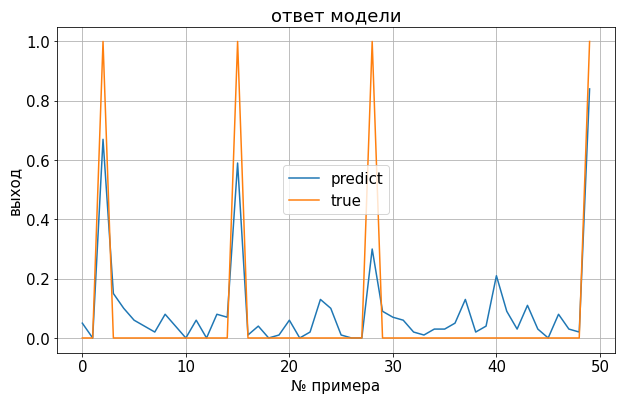

In [255]:
n = 50
plt.figure(figsize=(10, 6))
plt.plot(preds_3[:n], label='predict')
plt.plot(y_3_test.values[:n], label='true')
plt.title('ответ модели')
plt.xlabel('№ примера')
plt.ylabel('выход')
plt.legend()
plt.grid('On')
plt.show()

In [256]:
precision_3, recall_3, thresholds_3 = precision_recall_curve(y_test, preds_3)
# print(precision_2 + recall_2)
fscore_3 = (2 * precision_3 * recall_3) / (precision_3 + recall_3)
# locate the index of the largest f score
ix_3 = np.argmax(fscore_3)
print(f'Best Threshold={thresholds_3[ix_3]}, F-Score={fscore_3[ix_3]:.3f}, Precision={precision_3[ix_3]:.3f}, Recall={recall_3[ix_3]:.3f}')     

Best Threshold=0.38, F-Score=0.798, Precision=0.832, Recall=0.767


Confusion matrix, without normalization
[[1720   35]
 [  61  184]]


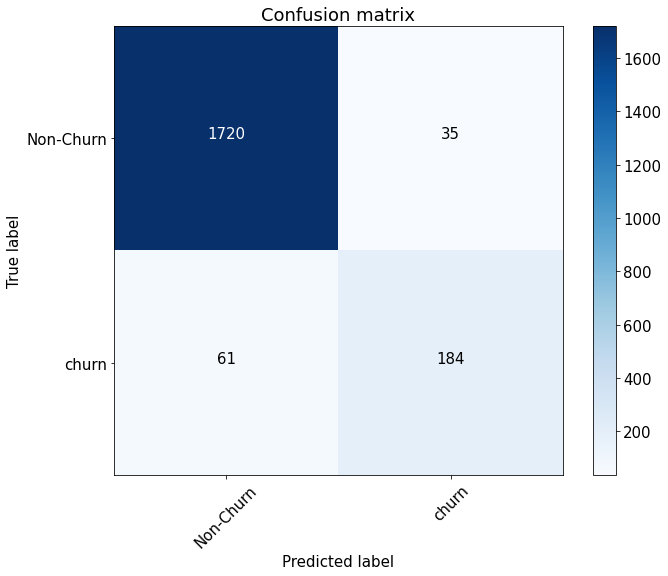

In [257]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_3 = confusion_matrix(y_3_test, preds_3 > thresholds_3[ix_3])

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_3, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [258]:
roc_auc_3 = roc_auc_score(y_3_test, preds_3)
roc_auc_3

0.974151985580557

4. Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.

In [259]:
from gensim.models import LdaModel, TfidfModel

In [260]:
tfidf_model = TfidfModel(common_corpus)
common_corpus_tfidf = [tfidf_model[doc] for doc in common_corpus]
lda_tfidf = LdaModel(common_corpus_tfidf, num_topics=25, id2word=common_dictionary)

In [261]:
def get_lda_vector_tfidf(text):
    unseen_doc = tfidf_model[common_dictionary.doc2bow(text)]
    lda_tuple = lda_tfidf[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(N_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [262]:
topic_matrix_tfidf = pd.DataFrame([get_lda_vector_tfidf(text) for text in news['title'].values])
topic_matrix_tfidf.columns = ['topic_{}'.format(i) for i in range(N_topic)]
topic_matrix_tfidf['doc_id'] = news['doc_id'].values
topic_matrix_tfidf = topic_matrix_tfidf[['doc_id']+['topic_{}'.format(i) for i in range(N_topic)]]
doc_dict = dict(zip(topic_matrix_tfidf['doc_id'].values, topic_matrix_tfidf[['topic_{}'.format(i) for i in range(N_topic)]].values))

In [263]:
%%time
user_embeddings_4 = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x))])
user_embeddings_4.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings_4['uid'] = users['uid'].values
user_embeddings_4 = user_embeddings_4[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings_4.head(3)

Wall time: 375 ms


,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.008158,0.059158,0.048174,0.008158,0.008158,0.018823,0.035785,0.013388,0.016797,...,0.008158,0.025816,0.502962,0.085873,0.008158,0.008158,0.016934,0.008158,0.008158,0.008158
1,u108690,0.000000,0.072406,0.034317,0.000000,0.010005,0.000000,0.042297,0.004095,0.026990,...,0.000000,0.004585,0.533601,0.127345,0.000000,0.000000,0.005763,0.006125,0.000000,0.000000
2,u108339,0.000000,0.069966,0.044394,0.000000,0.027155,0.000000,0.039230,0.000000,0.019643,...,0.000000,0.006651,0.481812,0.135410,0.000000,0.000000,0.012606,0.004123,0.000000,0.012899


In [264]:
user_embeddings_4.head()

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.008158,0.059158,0.048174,0.008158,0.008158,0.018823,0.035785,0.013388,0.016797,...,0.008158,0.025816,0.502962,0.085873,0.008158,0.008158,0.016934,0.008158,0.008158,0.008158
1,u108690,0.000000,0.072406,0.034317,0.000000,0.010005,0.000000,0.042297,0.004095,0.026990,...,0.000000,0.004585,0.533601,0.127345,0.000000,0.000000,0.005763,0.006125,0.000000,0.000000
2,u108339,0.000000,0.069966,0.044394,0.000000,0.027155,0.000000,0.039230,0.000000,0.019643,...,0.000000,0.006651,0.481812,0.135410,0.000000,0.000000,0.012606,0.004123,0.000000,0.012899
3,u101138,0.001852,0.052044,0.016541,0.001852,0.001852,0.001852,0.044987,0.001852,0.001852,...,0.001852,0.001852,0.606094,0.086284,0.001852,0.001852,0.014885,0.011345,0.001852,0.001852
4,u108248,0.001990,0.077148,0.093920,0.001990,0.001990,0.001990,0.020602,0.001990,0.023497,...,0.001990,0.023112,0.462019,0.126902,0.001990,0.001990,0.001990,0.001990,0.001990,0.001990


In [265]:
X_4 = pd.merge(user_embeddings_4, target, 'left')
X_4.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.008158,0.059158,0.048174,0.008158,0.008158,0.018823,0.035785,0.013388,0.016797,...,0.025816,0.502962,0.085873,0.008158,0.008158,0.016934,0.008158,0.008158,0.008158,0
1,u108690,0.000000,0.072406,0.034317,0.000000,0.010005,0.000000,0.042297,0.004095,0.026990,...,0.004585,0.533601,0.127345,0.000000,0.000000,0.005763,0.006125,0.000000,0.000000,1
2,u108339,0.000000,0.069966,0.044394,0.000000,0.027155,0.000000,0.039230,0.000000,0.019643,...,0.006651,0.481812,0.135410,0.000000,0.000000,0.012606,0.004123,0.000000,0.012899,1


In [266]:
X_4_train, X_4_test, y_4_train, y_4_test = train_test_split(X_4[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X_4['churn'], random_state=0)
logreg_4 = RandomForestClassifier()
logreg_4.fit(X_4_train, y_4_train)
preds_4 = logreg_4.predict_proba(X_4_test)[:, 1]
preds_4[:10]

array([0.12, 0.  , 0.85, 0.02, 0.  , 0.  , 0.  , 0.  , 0.  , 0.27])

In [267]:
print(preds_4)

[0.12 0.   0.85 ... 0.   0.   0.  ]


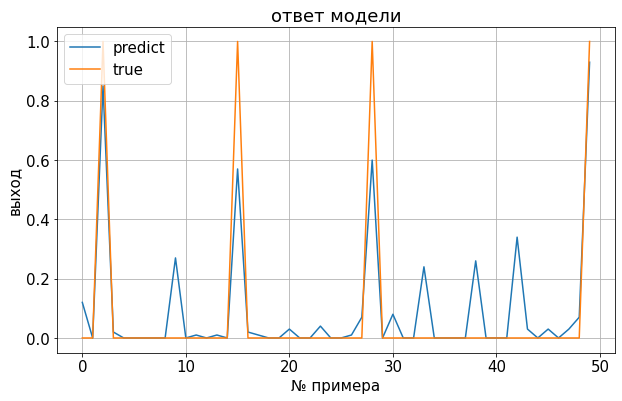

In [268]:
n = 50
plt.figure(figsize=(10, 6))
plt.plot(preds_4[:n], label='predict')
plt.plot(y_4_test.values[:n], label='true')
plt.title('ответ модели')
plt.xlabel('№ примера')
plt.ylabel('выход')
plt.legend()
plt.grid('On')
plt.show()

In [269]:
# precision_4, recall_4, thresholds_4 = precision_recall_curve(y_test, np.round(abs(preds_4))) #preds_4)
precision_4, recall_4, thresholds_4 = precision_recall_curve(y_test, preds_4)
fscore_4 = (2 * precision_4 * recall_4) / (precision_4 + recall_4)
# locate the index of the largest f score
ix_4 = np.argmax(fscore_4)
print(f'Best Threshold={thresholds_4[ix_4]}, F-Score={fscore_4[ix_4]:.3f}, Precision={precision_4[ix_4]:.3f}, Recall={recall_4[ix_4]:.3f}') 

Best Threshold=0.39, F-Score=0.787, Precision=0.767, Recall=0.808


Confusion matrix, without normalization
[[1696   59]
 [  49  196]]


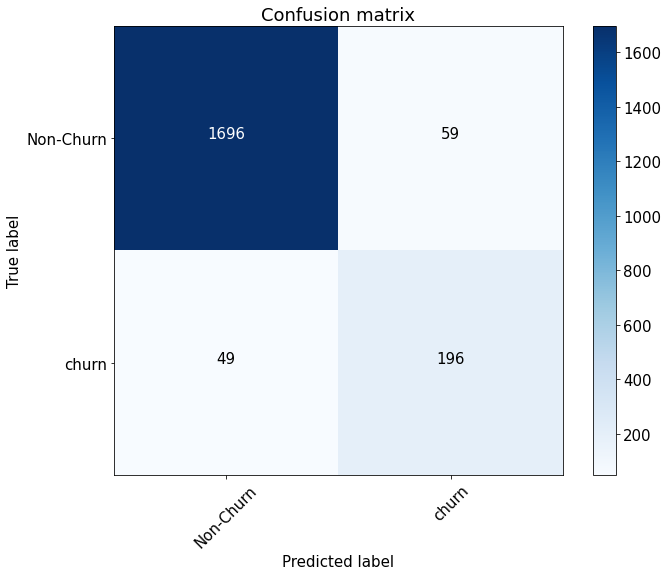

In [270]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_4 = confusion_matrix(y_4_test, preds_4 > thresholds_4[ix_4])

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_4, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [271]:
roc_auc_4 = roc_auc_score(y_4_test, preds_4)
roc_auc_4

0.9751485551485553

5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

In [272]:
df=pd.DataFrame(
    {
        'methods':['mean', 'median','max','idf_mean ']
        ,'roc_auc':[roc_auc, roc_auc_2, roc_auc_3, roc_auc_4]
        ,'precision': [precision[ix], precision_2[ix_2], precision_3[ix_3], precision_4[ix_4]]
        ,'recall': [recall[ix], recall_2[ix_2], recall_3[ix_3], recall_4[ix_4]]
        ,'f_score': [fscore[ix], fscore_2[ix_2], fscore_3[ix_3], fscore_4[ix_4]]
    }
)
df

,methods,roc_auc,precision,recall,f_score
0,mean,0.970611,0.881279,0.787755,0.831897
1,median,0.996823,0.922780,0.975510,0.948413
2,max,0.974152,0.831858,0.767347,0.798301
3,idf_mean,0.975149,0.767442,0.808163,0.787276


6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

Показатели по медиане несколько лучше, чем по максимальному значению или среднему, т.к. медиана более устойчива к выбросам. 